In [1]:
from platform import python_version
print(python_version())

3.7.10


A: The usage of the data set is unrestricted. But you should provide the link to our original download site, acknowledge the NIH Clinical Center and provide a citation to our CVPR 2017 paper

A: ‘No finding’ means the 14 listed disease patterns are not found in the image. 

https://www.kaggle.com/nih-chest-xrays/data

Citations
Wang X, Peng Y, Lu L, Lu Z, Bagheri M, Summers RM. ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases. IEEE CVPR 2017, ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf

NIH News release: NIH Clinical Center provides one of the largest publicly available chest x-ray datasets to scientific community

Original source files and documents: https://nihcc.app.box.com/v/ChestXray-NIHCC/folder/36938765345

### Context Behind Dataset for Final Writeup:

Dataset was gathered by the NIH and contains over 100,000 anonymized chest x-ray images from more than 30,000 patients.  

# Goal
The goal is to use a simple model to classify x-ray images in Keras

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
/home/ubuntu/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
import tensorflow

In [4]:
all_xray_df = pd.read_csv('../data/Data_Entry_2017.csv')
folderlist = glob(os.path.join('../data', 'images*'))
imglist = []
for folder in folderlist:
    tmp = glob(os.path.join(folder, "images", "*.png"))
    imglist += tmp
all_image_paths = {os.path.basename(x): x for x in imglist}
#{k:all_image_paths[k] for k in all_image_paths.keys()[:5]}
list(all_image_paths.items())[:4]
# all_image_paths = {os.path.basename(x): x for x in 
#                    glob(os.path.join('.', 'data', 'images*', '*.png'))}



[('00018942_001.png', '../data/images_009/images/00018942_001.png'),
 ('00020323_001.png', '../data/images_009/images/00020323_001.png'),
 ('00018730_001.png', '../data/images_009/images/00018730_001.png'),
 ('00019551_000.png', '../data/images_009/images/00019551_000.png')]

In [5]:
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
num_selected = 10000
tmp = {key: all_image_paths[key] for key in sorted(list(all_image_paths.keys()))[num_selected:]}
print(list(tmp.items())[:4])
all_xray_df['path'] = all_xray_df['Image Index'][num_selected:].map(tmp.get)
all_xray_df = all_xray_df[num_selected:]
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120
[('00002587_005.png', '../data/images_002/images/00002587_005.png'), ('00002588_000.png', '../data/images_002/images/00002588_000.png'), ('00002589_000.png', '../data/images_002/images/00002589_000.png'), ('00002589_001.png', '../data/images_002/images/00002589_001.png')]


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
69681,00017166_000.png,Fibrosis,0,17166,78,F,PA,2666,2991,0.143,0.143,NaN,../data/images_008/images/00017166_000.png
89795,00022295_000.png,No Finding,0,22295,57,F,PA,2504,3040,0.139,0.139,NaN,../data/images_010/images/00022295_000.png
39119,00010253_000.png,No Finding,0,10253,23,F,PA,2992,2991,0.143,0.143,NaN,../data/images_005/images/00010253_000.png


In [6]:
label_counts = all_xray_df['Finding Labels'].value_counts()
label_counts

No Finding                                                                 54652
Infiltration                                                                8734
Atelectasis                                                                 3848
Effusion                                                                    3659
Nodule                                                                      2495
Mass                                                                        2015
Pneumothorax                                                                1972
Effusion|Infiltration                                                       1511
Atelectasis|Infiltration                                                    1237
Consolidation                                                               1199
Atelectasis|Effusion                                                        1091
Pleural_Thickening                                                          1004
Cardiomegaly                

# Preprocessing Labels
Here we take the labels and make them into a more clear format. The primary step is to see the distribution of findings and then to convert them to simple binary labels

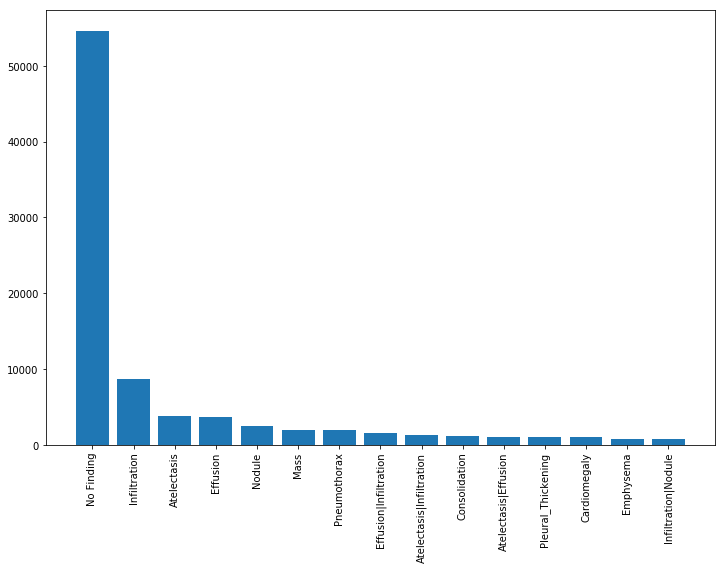

In [7]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [8]:
n_priorities = 4
priority1=['Pneumothorax']
priority2=['Pneumonia','Edema']
priority3=['Atelectasis','Cardiomegaly','Consolidation','Effusion','Emphysema','Fibrosis','Infiltration','Mass','Nodule','Pleural_Thickening']
priority4=['No Finding']

In [9]:
def priority_val(x):
    if any(item in priority1 for item in x):
        return 'priority1'
    elif any(item in priority2 for item in x):
        return 'priority2'
    elif any(item in priority3 for item in x):
        return 'priority3'
    elif any(item in priority4 for item in x):
        return 'priority4'
    
    

In [10]:
from itertools import chain
all_xray_df['Priority Label']=all_xray_df['Finding Labels'].map(lambda x: priority_val(x.split('|')))
all_xray_df['Priority Label'].sample(3)

82410    priority3
44959    priority2
28545    priority4
Name: Priority Label, dtype: object

In [11]:
#all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
67724,00016732_026.png,Effusion,26,16732,80,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79750,00019592_010.png,No Finding,10,19592,52,M,AP,2544,3056,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
41818,00010785_003.png,Atelectasis|Infiltration|Nodule,3,10785,70,M,PA,2846,2825,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [12]:
all_labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

### Clean categories
Since we have too many categories, we can prune a few out by taking the ones with only a few examples

In [13]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

Clean Labels (14) [('Atelectasis', 10670), ('Cardiomegaly', 2476), ('Consolidation', 4271), ('Edema', 2150), ('Effusion', 12410), ('Emphysema', 2295), ('Fibrosis', 1407), ('Infiltration', 18291), ('Mass', 5454), ('No Finding', 54652), ('Nodule', 5887), ('Pleural_Thickening', 3060), ('Pneumonia', 1296), ('Pneumothorax', 4862)]


In [14]:

res = [i for i, val in enumerate(list(all_xray_df['Priority Label'])) if val == None]


In [15]:
all_xray_df['Priority Label']
res = [i for i, val in enumerate(list(all_xray_df['Priority Label'])) if val == None]
print(res)

[1589, 1590, 1591, 1592, 2428, 2525, 5023, 5024, 5579, 6034, 9541, 9590, 11551, 12815, 13240, 14244, 14781, 15532, 15536, 16160, 18209, 19618, 20263, 20280, 20754, 22253, 22528, 23133, 23135, 23137, 24265, 27971, 28351, 36105, 36669, 37468, 39653, 40594, 40972, 42639, 43035, 43038, 43043, 43048, 44689, 44822, 44823, 44824, 46170, 46797, 48269, 59434, 59781, 62160, 63688, 64700, 67454, 67543, 67544, 70765, 73006, 74376, 74874, 74875, 74876, 74877, 76994, 77002, 77003, 78462, 78588, 78821, 81356, 84724, 84734, 84878, 87051, 90738, 90847, 92747, 93654, 95367, 97271, 97273, 97276, 97927, 98497, 99616]


In [16]:
res = [i for i, val in enumerate(list(all_xray_df['Priority Label'])) if val == None]
res
rows=all_xray_df.index[res]
all_xray_df=all_xray_df.drop(rows)

In [17]:
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
59969,00014802_000.png,No Finding,0,14802,39,M,PA,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
99051,00026197_005.png,No Finding,5,26197,41,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
64578,00015940_002.png,No Finding,2,15940,53,F,PA,1853,1834,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [18]:
np.unique(list(all_xray_df['Priority Label']))

array(['priority1', 'priority2', 'priority3', 'priority4'], dtype='<U9')

In [19]:
all_priorities = np.unique(all_xray_df['Priority Label'])
#all_priorities = [x for x in all_priorities if len(x)>0]
all_priorities

array(['priority1', 'priority2', 'priority3', 'priority4'], dtype=object)

In [20]:
print('All Priorities ({}): {}'.format(len(all_priorities), all_priorities))
for p_label in all_priorities:
    if len(p_label)>1: # leave out empty labels
        all_xray_df[p_label] = all_xray_df['Priority Label'].map(lambda finding: 1.0 if p_label in finding else 0)
all_xray_df.sample(3)

All Priorities (4): ['priority1' 'priority2' 'priority3' 'priority4']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,priority1,priority2,priority3,priority4
30053,00007831_000.png,No Finding,0,7831,44,F,PA,2048,2500,0.168,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
83218,00020437_004.png,Nodule|Pneumothorax,4,20437,56,F,PA,2992,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
15354,00004006_075.png,No Finding,75,4006,38,F,PA,2992,2991,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [21]:
for c_label, s_count in zip(all_labels, np.mean(all_xray_df[all_labels].values,0)):
    print('%s: %f' % (c_label, s_count))
arrivals=np.array(np.mean(all_xray_df[all_labels].values,0))
arrivals=arrivals/arrivals.sum(axis=0,keepdims=True)
disease_priority=np.array([[0,0,1,0],[0,0,1,0],[0,0,1,0],[0,1,0,0],[0,0,1,0],
                  [0,0,1,0],[0,0,1,0],[0,0,1,0],[0,0,1,0],[0,0,0,1],
                  [0,0,1,0],[0,0,1,0],[0,1,0,0],[1,0,0,0]])
print(arrivals)
priority_arrivals=np.array(np.mean(all_xray_df[all_priorities].values,0))
print(priority_arrivals)

Atelectasis: 0.104575
Cardiomegaly: 0.024267
Consolidation: 0.041859
Edema: 0.021072
Effusion: 0.121629
Emphysema: 0.022493
Fibrosis: 0.013790
Infiltration: 0.179267
Mass: 0.053454
No Finding: 0.535636
Nodule: 0.057698
Pleural_Thickening: 0.029991
Pneumonia: 0.012702
Pneumothorax: 0.047652
[0.08259729 0.01916691 0.03306214 0.01664331 0.09606676 0.01776577
 0.01089169 0.14159203 0.04221983 0.42306531 0.04557172 0.02368769
 0.01003244 0.03763711]
[0.04765172 0.0300886  0.3866238  0.53563588]


In [22]:
print(all_xray_df[all_labels].sum())
print(all_xray_df[all_priorities].sum())

Atelectasis           10670.0
Cardiomegaly           2476.0
Consolidation          4271.0
Edema                  2150.0
Effusion              12410.0
Emphysema              2295.0
Fibrosis               1407.0
Infiltration          18291.0
Mass                   5454.0
No Finding            54652.0
Nodule                 5887.0
Pleural_Thickening     3060.0
Pneumonia              1296.0
Pneumothorax           4862.0
dtype: float64
priority1     4862.0
priority2     3070.0
priority3    39448.0
priority4    54652.0
dtype: float64


In [23]:
all_xray_df1 = all_xray_df[all_xray_df['Priority Label'] == "priority1"].sample(frac=5,replace=True)


In [24]:
all_xray_df2 = all_xray_df[all_xray_df['Priority Label'] == "priority2"].sample(frac=10,replace=True)

In [25]:
all_xray_df3 = all_xray_df[all_xray_df['Priority Label'] == "priority3"].sample(frac=5,replace=True)

In [26]:
all_xray_df_bal = pd.concat([all_xray_df,all_xray_df1,all_xray_df2,all_xray_df3],ignore_index=True)

In [27]:
all_xray_df_bal=all_xray_df_bal.sample(frac=0.5)

In [28]:
print(all_xray_df_bal[all_priorities].sum())

priority1     14541.0
priority2     16758.0
priority3    118367.0
priority4     27475.0
dtype: float64


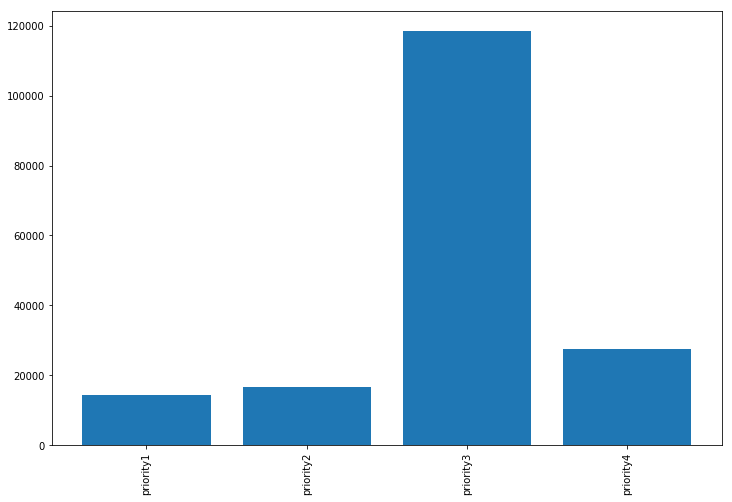

In [29]:
label_counts = all_xray_df_bal[all_priorities].sum()
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

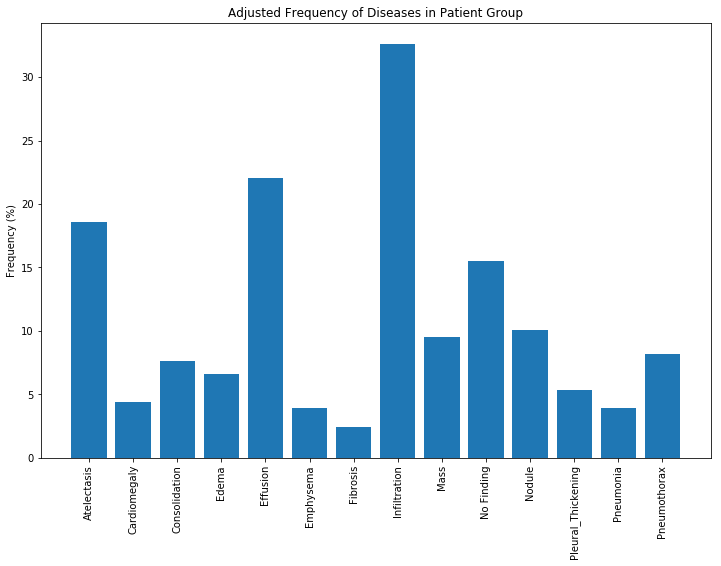

In [30]:
label_counts = 100*np.mean(all_xray_df_bal[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

# Prepare Training Data
Here we split the data into training and validation sets and create a single vector (disease_vec) with the 0/1 outputs for the disease status (what the model will try and predict)

In [31]:
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])
all_xray_df['priority_vec'] = all_xray_df.apply(lambda x: [x[all_priorities].values], 1).map(lambda x: x[0])

In [32]:
print(all_xray_df['disease_vec'].sample(3))
print(all_xray_df['priority_vec'].sample(3))

24310    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
74740    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
31884    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: disease_vec, dtype: object
98094    [0.0, 0.0, 0.0, 1.0]
20681    [0.0, 0.0, 1.0, 0.0]
47778    [0.0, 0.0, 0.0, 1.0]
Name: priority_vec, dtype: object


In [33]:
all_xray_df_bal['disease_vec'] = all_xray_df_bal.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])
all_xray_df_bal['priority_vec'] = all_xray_df_bal.apply(lambda x: [x[all_priorities].values], 1).map(lambda x: x[0])

In [34]:
print(all_xray_df_bal['disease_vec'].sample(3))
print(all_xray_df_bal['priority_vec'].sample(3))

37424     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
73774     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
109466    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: disease_vec, dtype: object
247270    [0.0, 0.0, 1.0, 0.0]
47095     [0.0, 0.0, 0.0, 1.0]
69164     [0.0, 0.0, 1.0, 0.0]
Name: priority_vec, dtype: object


In [35]:
df=all_xray_df.sample(40000)
from sklearn.model_selection import train_test_split
valid_df, test_df = train_test_split(df, 
                                   test_size = 0.5, 
                                   random_state = 2018,
                                   stratify = df['Priority Label'])

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1462: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1462: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to revie

In [36]:
train_df = all_xray_df_bal

In [37]:
print('train', train_df.shape, 'validation', valid_df.shape,'test', test_df.shape)

train (177141, 35) validation (20000, 35) test (20000, 35)


In [38]:
train_df['newLabel'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
train_df['newLabelP'] = train_df['Priority Label']
print(train_df.sample(3))

             Image Index                               Finding Labels  \
269564  00012509_009.png                                 Infiltration   
25608   00009386_001.png                                   No Finding   
72983   00020408_017.png  Atelectasis|Consolidation|Infiltration|Mass   

        Follow-up #  Patient ID  Patient Age Patient Gender View Position  \
269564            9       12509           60              M            PA   
25608             1        9386           30              F            AP   
72983            17       20408           45              M            AP   

        OriginalImage[Width  Height]  OriginalImagePixelSpacing[x  ...  \
269564                 2992     2991                        0.143  ...   
25608                  2048     2500                        0.168  ...   
72983                  2752     2544                        0.139  ...   

        Pneumonia  Pneumothorax priority1 priority2  priority3  priority4  \
269564        0.0       

In [39]:
valid_df['newLabel'] = valid_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
valid_df['newLabelP'] = valid_df['Priority Label']
print(valid_df.sample(3))

            Image Index         Finding Labels  Follow-up #  Patient ID  \
13490  00003510_011.png  Effusion|Infiltration           11        3510   
90831  00022615_000.png            Atelectasis            0       22615   
23620  00006253_001.png             No Finding            1        6253   

       Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
13490           38              F            PA                 2992     2991   
90831           63              F            PA                 2488     3056   
23620           48              F            PA                 2048     2500   

       OriginalImagePixelSpacing[x  ...  Pneumonia  Pneumothorax priority1  \
13490                        0.143  ...        0.0           0.0       0.0   
90831                        0.139  ...        0.0           0.0       0.0   
23620                        0.171  ...        0.0           0.0       0.0   

      priority2  priority3  priority4  \
13490       0.0     

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [40]:
test_df['newLabel'] = test_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
test_df['newLabelP'] = test_df['Priority Label']
print(test_df.sample(3))

            Image Index                 Finding Labels  Follow-up #  \
74434  00018259_001.png                     No Finding            1   
78918  00019373_005.png  Emphysema|Nodule|Pneumothorax            5   
40254  00010484_014.png                     No Finding           14   

       Patient ID  Patient Age Patient Gender View Position  \
74434       18259           56              M            AP   
78918       19373           39              M            PA   
40254       10484           59              F            PA   

       OriginalImage[Width  Height]  OriginalImagePixelSpacing[x  ...  \
74434                 2500     2048                        0.168  ...   
78918                 3056     2544                        0.139  ...   
40254                 2986     2991                        0.143  ...   

       Pneumonia  Pneumothorax priority1 priority2  priority3  priority4  \
74434        0.0           0.0       0.0       0.0        0.0        1.0   
78918        0.0 

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
import tensorflow as tf
def queue_wait_cost(pmat,costs,arrivals,service):
    clambda = costs*arrivals
    rho = arrivals/service
    clambda_pmat = np.matmul(clambda,pmat)
    rho_pmat = np.matmul(rho,pmat)
    vec1=1-np.cumsum(rho_pmat)
    vec2=np.roll(1-np.cumsum(rho_pmat),1)
    vec2[0]=1
    denom = (1/vec1)*(1/vec2)
    return sum(clambda_pmat*denom)
def queue_wait_cost_priority(pmat,priority_costs,priority_arrivals,priority_service):
    clambda = priority_costs*priority_arrivals
    rho = priority_arrivals/priority_service
    clambda_pmat = np.matmul(clambda,pmat)
    rho_pmat = np.matmul(rho,pmat)
    vec1=1-np.cumsum(rho_pmat)
    vec2=np.roll(1-np.cumsum(rho_pmat),1)
    vec2[0]=1
    denom = (1/vec1)*(1/vec2)
    return sum(clambda_pmat*denom)
def queue_loss(y_true,y_pred):
    y_pred = y_pred/y_pred.sum(axis=1,keepdims=True)
    pmat = np.matmul(np.transpose(y_true),y_pred)
    pmat = pmat/pmat.sum(axis=1,keepdims=True)
    clambda = costs*arrivals
    rho = arrivals/service
    clambda_pmat = np.matmul(clambda,pmat)
    rho_pmat = np.matmul(rho,pmat)
    vec1=1-np.cumsum(rho_pmat)
    vec2=np.roll(1-np.cumsum(rho_pmat),1)
    vec2[0]=1
    denom = (1/vec1)*(1/vec2)
    return sum(clambda_pmat*denom)

def queue_loss_tensor(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    #y_pred = tf.divide(y_pred,tf.reduce_sum(y_pred,axis=1,keepdims=True)+0.000000000001)
    pmat = tf.matmul(tf.transpose(y_true),y_pred)
    pmat = tf.divide(pmat,tf.reduce_sum(pmat,axis=1,keepdims=True)+0.000000000001)
    clambda = tf.reshape(tf.cast(tf.Variable(costs*arrivals),tf.float32),[1,14])
    rho = tf.reshape(tf.cast(tf.Variable(arrivals/service),tf.float32),[1,14])
    #print(rho.shape)
    clambda_pmat = tf.matmul(clambda,pmat)
    rho_pmat = tf.matmul(rho,pmat)
    vec1=1-tf.cumsum(rho_pmat,axis=1)
    #print(vec1)
    vec2=tf.roll(1-tf.cumsum(rho_pmat,axis=1),shift=1,axis=1)
    #print(vec2)
    vec2=tf.tensor_scatter_nd_update(vec2,indices=[[0,0]],updates=[1])
    #print(vec2)
    #print (tf.math.reciprocal(vec2))
    denom = tf.multiply(tf.math.reciprocal(vec1+0.00000000000001),tf.math.reciprocal(vec2+0.00000000000001))
    return tf.reshape(tf.reduce_sum(tf.multiply(clambda_pmat,denom)),[])
def queue_loss_tensor_priority(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    #y_pred = tf.divide(y_pred,tf.reduce_sum(y_pred,axis=1,keepdims=True)+0.000000000001)
    pmat = tf.matmul(tf.transpose(y_true),y_pred)
    pmat = tf.divide(pmat,tf.reduce_sum(pmat,axis=1,keepdims=True)+0.000000000001)
    clambda = tf.reshape(tf.cast(tf.Variable(priority_costs*priority_arrivals),tf.float32),[1,n_priorities])
    rho = tf.reshape(tf.cast(tf.Variable(priority_arrivals/priority_service),tf.float32),[1,n_priorities])
    #print(rho.shape)
    clambda_pmat = tf.matmul(clambda,pmat)
    rho_pmat = tf.matmul(rho,pmat)
    vec1=1-tf.cumsum(rho_pmat,axis=1)
    #print(vec1)
    vec2=tf.roll(1-tf.cumsum(rho_pmat,axis=1),shift=1,axis=1)
    #print(vec2)
    vec2=tf.tensor_scatter_nd_update(vec2,indices=[[0,0]],updates=[1])
    #print(vec2)
    #print (tf.math.reciprocal(vec2))
    denom = tf.multiply(tf.math.reciprocal(vec1+0.00000000000001),tf.math.reciprocal(vec2+0.00000000000001))
    return tf.reshape(tf.reduce_sum(tf.multiply(clambda_pmat,denom)),[])
    

# Training the Model

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from keras import optimizers, callbacks, regularizers

Using TensorFlow backend.


In [ ]:
def MakeModel1(IMG_SIZE, bs, channels=1):
    model = Sequential()
    base_mobilenet_model = MobileNet(input_shape =  (*IMG_SIZE, channels), #Need to define the shape here from IMG_SIZE
                                 include_top = False, weights = None)
    model.add(base_mobilenet_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(Dense(len(all_labels), activation = 'sigmoid'))
    return model
def MakeModel2(n_priorities,IMG_SIZE, bs, channels=1):
    model = Sequential()
    base_mobilenet_model = MobileNet(input_shape =  (*IMG_SIZE, channels), #Need to define the shape here from IMG_SIZE
                                 include_top = False, weights = None)
    model.add(base_mobilenet_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(Dense(len(all_labels),activation = 'sigmoid'))
    model.add(Dense(n_priorities, activation = 'softmax'))
    return model
def MakeModel3(n_priorities,IMG_SIZE, bs, channels=1):
    model = Sequential()
    base_mobilenet_model = MobileNet(input_shape =  (*IMG_SIZE, channels), #Need to define the shape here from IMG_SIZE
                                 include_top = False, weights = None)
    model.add(base_mobilenet_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(Dense(n_priorities, activation = 'softmax'))
    return model

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [ ]:
n_priorities=4

In [ ]:
lr = 0.0005
syntheticBatch = 256
imageSize = (512, 512)
colorMode = 'rgb'
channels = 3
batchSize = 32
batch = int(256 / batchSize)
STEPS_PER_EPOCH = 1000
EPOCHS = 100
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.sequential.june9.hdf5".format('xray_class')
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5)
callbacks_list = [checkpoint, early]


train_gen = core_idg.flow_from_dataframe(dataframe=train_df, 
                         directory=None,
                         x_col = 'path',
                        y_col = 'newLabel', 
                         class_mode = 'categorical',
                        classes = all_labels,
                        target_size = imageSize,
                         color_mode = colorMode,
                        batch_size = batchSize)

valid_gen = core_idg.flow_from_dataframe(dataframe=valid_df, 
                         directory=None,
                         x_col = 'path',
                        y_col = 'newLabel', 
                         class_mode = 'categorical',
                        classes = all_labels,
                        target_size = imageSize,
                         color_mode = colorMode,
                        batch_size = batchSize) # we can use much larger batches for evaluation


opt = tensorflow.keras.optimizers.Adam(
    learning_rate=lr,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
)


Found 177141 validated image filenames belonging to 14 classes.
Found 20000 validated image filenames belonging to 14 classes.


In [ ]:
import gc
gc.collect()
multi_disease_model = MakeModel1(imageSize, batchSize, channels)
multi_disease_model.load_weights("xray_class_weights.best.sequential.june9.hdf5")


In [ ]:
multi_disease_model.compile(optimizer = opt, loss = 'binary_crossentropy',
       metrics = ['binary_accuracy', 'mae'])

history = multi_disease_model.fit_generator(train_gen,                           
              validation_data = valid_gen, 
              steps_per_epoch=1000,                              
              epochs = 20, 
              callbacks = callbacks_list)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
 356/1000 [=========>....................] - ETA: 27:03 - loss: 0.2952 - binary_accuracy: 0.8928 - mae: 0.1702

In [51]:
history.history

{'loss': [0.293517142534256,
  0.2906646132469177,
  0.28866204619407654,
  0.28455397486686707,
  0.28173625469207764,
  0.2793566584587097,
  0.2774037718772888,
  0.2750694155693054],
 'binary_accuracy': [0.8931008577346802,
  0.8937939405441284,
  0.8938009142875671,
  0.8942359089851379,
  0.8951245546340942,
  0.8951717019081116,
  0.8958483338356018,
  0.8961988687515259],
 'mae': [0.16969558596611023,
  0.16810785233974457,
  0.16755330562591553,
  0.1655551791191101,
  0.16390125453472137,
  0.16296105086803436,
  0.16164104640483856,
  0.1604762077331543],
 'val_loss': [0.24629133939743042,
  0.3181089758872986,
  0.2400800585746765,
  0.2460232675075531,
  0.24125993251800537,
  0.27051442861557007,
  0.24615275859832764,
  0.2511058449745178],
 'val_binary_accuracy': [0.9095287322998047,
  0.9020465612411499,
  0.9124106168746948,
  0.9095643758773804,
  0.9085497260093689,
  0.8985071182250977,
  0.903996467590332,
  0.9081324934959412],
 'val_mae': [0.152147576212883,
  0

In [61]:
test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=test_df, 
                             directory=None,
                             x_col = 'path',
                            y_col = 'newLabel', 
                             class_mode = 'categorical',
                            classes = all_labels,
                            target_size = imageSize,
                             color_mode = colorMode,
                            batch_size = 2000))

Found 20000 validated image filenames belonging to 14 classes.


In [62]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

63/63 [==============================] - 21s 341ms/step


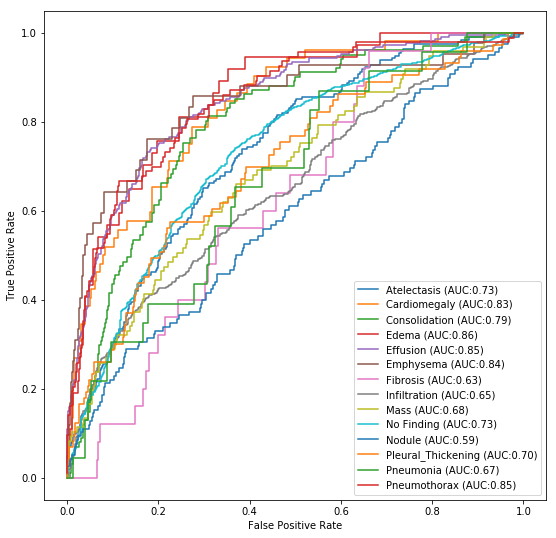

In [63]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.pdf')